# Sprint 6 - Predicting future environmental intensity (Time Series)

In this notebook, we will predict future environmental intensity for all the companies in the 'Excel data'. We will be using data from previous years to predict the future environmental intesity. 

First, we will create the following columns:

1) Industry Indicator
- 1 if above the industry average in current year
- 0 if at industry average in current yeat
- (-1) if below the industry average in current year
2) Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv('Environmental_Impact_dataset.csv')
column_list = []
for column in df.columns:
    column_list.append(column.replace(' ', ''))
df.columns = column_list
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
df.head(3)

The dataset has 14515 rows and 9 columns


,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,Environmental_Growth
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,NaN
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,NaN
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,33.333333


In [81]:
df = df.iloc[:,0:6]
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790


In [82]:
def percent_to_float(s):
    return float(s.strip('%')) / 100.0

replace_dict = {'(':'',')':'', ' ' : '', ',' : ''}
def paranthesis_to_minus(value):
    for i, j in replace_dict.items():
        value = value.replace(i, j)
    value = int(f'-{value}')
    return value

df['Env_intensity'] = df['EnvironmentalIntensity(Sales)'].apply(percent_to_float)

In [83]:
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790


### Creating industry indicator

In [84]:
industry_avg = df.groupby('Industry(Exiobase)')[['Env_intensity']].mean().reset_index()
df['industry_avg'] = df['Env_intensity'].groupby(df['Industry(Exiobase)']).transform('mean')

In [85]:
def create_ind(df):
    if(df['Env_intensity'] > df['industry_avg']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg']):
        return -1

df['Industry_indicator'] = df.apply(create_ind, axis = 1)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1


In [86]:
def create_ind_year(df):
    if(df['Env_intensity'] > df['industry_avg_year']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg_year']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg_year']):
        return -1

df['industry_avg_year'] = df.groupby(['Industry(Exiobase)','Year']).transform('mean')[['Env_intensity']]

df['Industry_indicator_year'] = df.apply(create_ind_year, axis = 1)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1


In [87]:
df.loc[(df['Industry(Exiobase)'] == 'Activities auxiliary to financial intermediation (67)'),:].sort_values(by='Year')

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
8166,2016,ADECCO GROUP AG,Switzerland,Activities auxiliary to financial intermediati...,-0.10%,-0.0010,-0.004417,1,-0.007880,1
14368,2016,WOLTERS KLUWER NV,Netherlands,Activities auxiliary to financial intermediati...,-0.20%,-0.0020,-0.004417,1,-0.007880,1
14123,2016,VERISK ANALYTICS INCORPORATION,United States,Activities auxiliary to financial intermediati...,-0.21%,-0.0021,-0.004417,1,-0.007880,1
13738,2016,TELEPERFORMANCE SE,France,Activities auxiliary to financial intermediati...,-1.10%,-0.0110,-0.004417,-1,-0.007880,-1
12891,2016,SAGA PLC,United Kingdom,Activities auxiliary to financial intermediati...,-2.82%,-0.0282,-0.004417,-1,-0.007880,-1
...,...,...,...,...,...,...,...,...,...,...
9736,2019,DKSH HOLDING AG,Switzerland,Activities auxiliary to financial intermediati...,-0.17%,-0.0017,-0.004417,1,0.002943,-1
10721,2019,HONG KONG EXCHANGES AND CLEARING LIMITED,Hong Kong,Activities auxiliary to financial intermediati...,-0.34%,-0.0034,-0.004417,1,0.002943,-1
10077,2019,EXPERIAN PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.20%,-0.0020,-0.004417,1,0.002943,-1
11536,2019,LONDON STOCK EXCHANGE GROUP PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.19%,-0.0019,-0.004417,1,0.002943,-1


### Creating Environmental growth

Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100

In [88]:
df = df.sort_values(by=['CompanyName','Year'], ascending = True)
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1


In [89]:
df['Environmental_Growth'] = df.groupby(['CompanyName'])['Env_intensity'].apply(lambda x: x.pct_change()).to_numpy() * 100
df.head()

,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year,Environmental_Growth
0,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.018382,1,-0.011640,1,NaN
1,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.12%,-0.0012,-0.020072,1,-0.006402,1,NaN
2,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.16%,-0.0016,-0.020072,1,-0.009838,1,33.333333
3,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance an...",-0.15%,-0.0015,-0.020072,1,-0.024437,1,-6.250000
4,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. ...,-7.90%,-0.0790,-0.117561,1,-0.084583,1,NaN


### Model 1 - Past years Environmental Intensity

In [90]:
df1 = pd.read_csv('Environmental_Impact_dataset.csv')


In [91]:
def p2f(x):
    return float(x.strip('%'))/100
df1['EnvironmentalIntensity(Sales)'] = df1['EnvironmentalIntensity(Sales)'].apply(p2f)

In [92]:
companies_2018 = list(df1[df1['Year'] == 2018]['CompanyName'])
companies_2019 = list(df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(companies_2018))]['CompanyName'])

#Getting companies that are in both years
list2018_as_set = set(companies_2018)
intersection = list2018_as_set.intersection(companies_2019)

X = df1[(df1['Year'] == 2018) & (df1['CompanyName'].isin(intersection))][['EnvironmentalIntensity(Sales)']]
y = df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(intersection))][['EnvironmentalIntensity(Sales)']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R2 score:', metrics.r2_score(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))


R2 score: 0.8825319170790614
MSE:  0.010786739663931545


### Model 2 - Past years average environmental intensity

In this section, we will use the average environmental intensity of 2016-2018 to predict 2019 environmental intensity

In [93]:
df2 = df.copy()
EI_2016 = df2[df2['Year'] == 2016]
EI_2017 = df2[df2['Year'] == 2017]
EI_2018 = df2[df2['Year'] == 2018]
EI_2019 = df2[df2['Year'] == 2019]

In [94]:
df_mod2 = EI_2016.merge(EI_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df_mod2 = df_mod2.merge(EI_2018, how='inner', on='CompanyName')
df_mod2 = df_mod2.merge(EI_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))

In [95]:
df_mod2 = df_mod2[['CompanyName','Year_2016','Env_intensity_2016','Year_2017','Env_intensity_2017','Year_2018','Env_intensity_2018','Year_2019','Env_intensity_2019']]

In [96]:
df_mod2.head()

,CompanyName,Year_2016,Env_intensity_2016,Year_2017,Env_intensity_2017,Year_2018,Env_intensity_2018,Year_2019,Env_intensity_2019
0,3M COMPANY,2016,-0.0705,2017,-0.0660,2018,-0.0710,2019,-0.0641
1,AA PLC,2016,-0.0130,2017,-0.0124,2018,-0.0117,2019,-0.0070
2,AAC TECHNOLOGIES HOLDINGS INCORPORATION,2016,-0.0389,2017,-0.0591,2018,-0.0802,2019,-0.1080
3,AAREAL BANK AG,2016,-0.0024,2017,-0.0021,2018,-0.0019,2019,-0.0015
4,AB SKF,2016,-0.0215,2017,-0.0226,2018,-0.0212,2019,-0.0200


In [97]:
df_melt2 = pd.melt(df_mod2, id_vars=['CompanyName'], value_vars=['Env_intensity_2016','Env_intensity_2016','Env_intensity_2017'],
        var_name='myVarname', value_name='Environmental_intenrsity')

In [98]:
df_melt2.head()

,CompanyName,myVarname,Environmental_intenrsity
0,3M COMPANY,Env_intensity_2016,-0.0705
1,AA PLC,Env_intensity_2016,-0.0130
2,AAC TECHNOLOGIES HOLDINGS INCORPORATION,Env_intensity_2016,-0.0389
3,AAREAL BANK AG,Env_intensity_2016,-0.0024
4,AB SKF,Env_intensity_2016,-0.0215


In [99]:
ei_avg = df_melt2.groupby('CompanyName').mean().reset_index()
X = ei_avg[['Environmental_intenrsity']]
y = df_mod2[['Env_intensity_2019']]

print(X.shape)
print(y.shape)

(833, 1)
(833, 1)


In [100]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.0038508976125549922


In [101]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  [0.00319838]
Model coefficients:  [[0.88787286]]


In [102]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.8949412998576046


### Model 3 - Yearly Industry Average

For this model, the predictor will be the industry average for the respective year. 
There is no data for 2020, so we plan to predict 2019 environmental intensity.  Accordingly, we used 2018 and 2017 Industry data (past data) to predict 2019 evronmental intensity. 

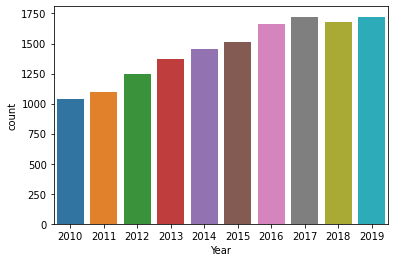

In [103]:
sns.countplot(x='Year', data = df)

The dataset does not contain consistent records throught out the years. Therefore, it could be possible we have data for one company in 2019 but not data from that company in 2018, 2017, etc. 

We will start by only using 2018 industry average as a feature to predict 2019 environmental intensity. First, we will subset the companies that we have 2018 data and get their 2019 environmental intensity.

In [104]:
df_2018 = df.loc[df.Year == 2018, ]
df_2019 = df.loc[df.Year == 2019, ]
df_mod3 = pd.merge(df_2018, df_2019, on='CompanyName',how='inner')
df_mod3 = df_mod3[['Year_x','CompanyName','industry_avg_year_x','Year_y','Env_intensity_y']]
df_mod3.head()

,Year_x,CompanyName,industry_avg_year_x,Year_y,Env_intensity_y
0,2018,3M COMPANY,-0.229308,2019,-0.0641
1,2018,3SBIO INC,-0.027793,2019,-0.0340
2,2018,A.G.V. PRODUCTS CORP,-0.072254,2019,-0.0172
3,2018,AA PLC,-0.073777,2019,-0.0070
4,2018,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.023555,2019,-0.1080


In [105]:
X = df_mod3[['industry_avg_year_x']]
y = df_mod3.iloc[:,4]
print(X.shape)
print(y.shape)

(1336, 1)
(1336,)


In [106]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.06598743409385226


In [107]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  0.0002669631900767411
Model coefficients:  [0.91303819]


In [108]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.36647102462935643


Now, we are going to consider 2017 - 2018 to predict 2019

In [109]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

In [110]:
df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','industry_avg_year']]
df2018.rename(columns={'industry_avg_year': 'Ind_Yearavg2018'}, inplace=True) 
df2017=df_2017[['CompanyName','industry_avg_year']]
df2017.rename(columns={'industry_avg_year': 'Ind_Yearavg2017'}, inplace=True) 
mdl = pd.merge(df2019, df2018, on=["CompanyName"])
mdl1= pd.merge(mdl, df2017, on=["CompanyName"])
mdl1

,Year,CompanyName,Env_intensity2019,Ind_Yearavg2018,Ind_Yearavg2017
0,2019,3M COMPANY,-0.0641,-0.229308,-0.225496
1,2019,3SBIO INC,-0.0340,-0.027793,-0.031771
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-0.072254,-0.063618
3,2019,AA PLC,-0.0070,-0.073777,-0.096157
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-0.023555,-0.027254
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-0.218707,-0.275385
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,-0.076812,-0.068294
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-0.124750,-0.117456
1193,2019,ZORLU ENERJI AS,-0.3430,-1.012140,-0.578986


In [111]:
X=mdl1[['Ind_Yearavg2018','Ind_Yearavg2017']]
y=mdl1['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [112]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = np.exp(regr.predict(X_train))
y_pred = np.exp(regr.predict(X_test))
y_test = np.exp(y_test)

In [113]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 1.064, test: 0.038


In [114]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.000576398328011471
Model coefficients:  [ 0.94555899 -0.06948928]


In [115]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.26873239153605155


Using the industry environmental average for 2017 and 2018 only explained 27% of the variation in the dataset. Let's see what happens including 2016-2018 to predict 2019

In [116]:
df_2016 = df.loc[df.Year == 2016, ]
df_2017 = df.loc[df.Year == 2017, ]
df1 = df_2016.merge(df_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df1 = df1.merge(df_2018, how='inner', on='CompanyName')
df1 = df1.merge(df_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))
df1 = df1[['Year_2016','industry_avg_year_2016','Year_2017','industry_avg_year_2017','Year_2018','industry_avg_year_2018','Year_2019','Env_intensity_2019']]

In [117]:
X = df1[['industry_avg_year_2016','industry_avg_year_2017','industry_avg_year_2018']]
y = df1.iloc[:,7]
print(X.shape)
print(y.shape)

(833, 3)
(833,)


In [118]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [119]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.034, test: 0.019


In [120]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.0007731215443031458
Model coefficients:  [ 0.63837237  0.20819909 -0.05038564]


In [121]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.4778572062782027


### Model 4 -Yearly Industry Indicator

For this model, we will consider the yearly industry indicator from past years to predict the company 2019 environmental intensity. 

We are going to start from 2017-2018 to predict 2019. 

In [122]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Industry_indicator_year']]
df2018.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Industry_indicator_year']]
df2017.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2017'}, inplace=True) 
mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017
0,2019,3M COMPANY,-0.0641,1,1
1,2019,3SBIO INC,-0.0340,-1,1
2,2019,A.G.V. PRODUCTS CORP,-0.0172,1,1
3,2019,AA PLC,-0.0070,1,1
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,1,1
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1,1
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-1,-1
1193,2019,ZORLU ENERJI AS,-0.3430,1,1


In [123]:
X=mdl4[['Ind_Indicator_2017','Ind_Indicator_2018']]
y=mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [124]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [125]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.048, test: 0.062


In [126]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.1535641068337678
Model coefficients:  [0.03709691 0.07830873]


In [127]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.21186363020947363


The industry indicator isn't a good predictor for environmental intensity. 

Let's try including 2016-2018 to predict 2019 environmental intensity. 

In [128]:
df_2016=df[df['Year'] == 2016]
df2016=df_2016[['CompanyName','Industry_indicator_year']]
df2016.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2016'}, inplace=True) 

mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2016, on=["CompanyName"])
mdl4.head()

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017,Ind_Indicator_2016
0,2019,3M COMPANY,-0.0641,1,1,1
1,2019,AA PLC,-0.0070,1,1,1
2,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1,-1
3,2019,AAREAL BANK AG,-0.0015,1,1,1
4,2019,AB SKF,-0.0200,1,1,1


In [129]:
X = mdl4[['Ind_Indicator_2016','Ind_Indicator_2017','Ind_Indicator_2018']]
y = mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(833, 3)
(833,)


In [130]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.045, test: 0.029


In [131]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.14239259821278608
Model coefficients:  [0.03012061 0.0131589  0.0676593 ]


In [132]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.21924492824372876


### Model 5 -Growth Rate

For this model, we will consider the growth rate from past years to predict the company 2019 environmental intensity.

We are going to start from 2017-2018 to predict 2019.

In [133]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Environmental_Growth']]
df2018.rename(columns={'Environmental_Growth': 'Environmental_Growth_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Environmental_Growth']]
df2017.rename(columns={'Environmental_Growth': 'Environmental_Growth_2017'}, inplace=True) 
mdl5 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2017, on=["CompanyName"])
mdl5

,Year,CompanyName,Env_intensity2019,Environmental_Growth_2018,Environmental_Growth_2017
0,2019,3M COMPANY,-0.0641,7.575758,-6.382979
1,2019,3SBIO INC,-0.0340,50.672646,NaN
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-26.315789,NaN
3,2019,AA PLC,-0.0070,-5.645161,-4.615385
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,35.702200,51.928021
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-1.272265,NaN
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1.990050,NaN
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-4.232425,-20.251716
1193,2019,ZORLU ENERJI AS,-0.3430,48.046057,-81.144737


In [134]:
mdl5.dropna(inplace = True)#delete rows with missing values
mdl5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 0 to 1194
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       833 non-null    int64  
 1   CompanyName                833 non-null    object 
 2   Env_intensity2019          833 non-null    float64
 3   Environmental_Growth_2018  833 non-null    float64
 4   Environmental_Growth_2017  833 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 39.0+ KB


In [135]:
X=mdl5[['Environmental_Growth_2017','Environmental_Growth_2018']]
y=mdl5['Env_intensity2019']
print(X.shape)
print(y.shape)

(833, 2)
(833,)


In [136]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [137]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.051, test: 0.037


In [138]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.09416744842653031
Model coefficients:  [-0.00012533 -0.00033923]


In [139]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: -0.0176694588355768


#### The growth rate isn't a good predictor for environmental intensity.
#### Let's try including 2016-2018 to predict 2019 environmental intensity.

In [145]:
df_2016=df[df['Year'] == 2016]
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 14508
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           1666 non-null   int64  
 1   CompanyName                    1666 non-null   object 
 2   Country                        1666 non-null   object 
 3   Industry(Exiobase)             1666 non-null   object 
 4   EnvironmentalIntensity(Sales)  1666 non-null   object 
 5   Env_intensity                  1666 non-null   float64
 6   industry_avg                   1666 non-null   float64
 7   Industry_indicator             1666 non-null   int64  
 8   industry_avg_year              1666 non-null   float64
 9   Industry_indicator_year        1666 non-null   int64  
 10  Environmental_Growth           323 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 156.2+ KB


In [147]:
df_2016=df[df['Year'] == 2016]
df2016=df_2016[['CompanyName','Environmental_Growth']]
df2016.rename(columns={'Environmental_Growth': 'Environmental_Growth_2016'}, inplace=True) 

mdl5 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2017, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2016, on=["CompanyName"])
mdl5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 0 to 832
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       833 non-null    int64  
 1   CompanyName                833 non-null    object 
 2   Env_intensity2019          833 non-null    float64
 3   Environmental_Growth_2018  833 non-null    float64
 4   Environmental_Growth_2017  833 non-null    float64
 5   Environmental_Growth_2016  0 non-null      float64
dtypes: float64(4), int64(1), object(1)
memory usage: 45.6+ KB


#### Unfortunately, there is no information for 2016 growth rate after merging

# Predicting Industry Based on Company Description

In [ ]:
tickers_df = pd.read_csv('Datasets/52_tickers_sectors.csv')

In [ ]:
tickers = tickers_df.Ticker

In [ ]:
# Create a loop to store URLs of all stocks' description page
URL = [] 
DES = [] 

for i in tickers: 
  url ='https://finance.yahoo.com/quote/'+i+'/profile' 
  URL.append(url)
  page = requests.get(url) # visits the URL 
  htmldata = BeautifulSoup(page.content, 'html.parser')
  Business_Description = htmldata.find('p',{'class':'Mt(15px) Lh(1.6)'}) # finds the business description part in the HTML code
  DES.append(Business_Description.text)

We will continue building a model in the next sprint!